# III_Trench Exciser
author: Camillo Moschner (cm967)

start: 28.04.2021

## Import Statements

In [1]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame
import os

from os import listdir
from glob import glob
from tqdm.notebook import tqdm

In [2]:
from PIL import Image
import napari
import seaborn as sns
from joblib import Parallel, delayed

from scipy import ndimage as ndi
from sklearn.cluster import DBSCAN
from scipy.ndimage.morphology import grey_opening, grey_closing, grey_dilation, grey_erosion, binary_erosion, binary_opening, binary_closing, binary_dilation
from skimage.filters import threshold_otsu, threshold_niblack,threshold_sauvola, gaussian
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rescale, resize, downscale_local_mean, rotate

from scipy.signal import find_peaks
from tifffile import TiffFile, imread, memmap

/var/folders/p_/d1kqy0fj5497sqkd5nkn_rf40000gn/T/ipykernel_5753/3672906265.py:8: DeprecationWarning: Please use `grey_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import grey_opening, grey_closing, grey_dilation, grey_erosion, binary_erosion, binary_opening, binary_closing, binary_dilation
/var/folders/p_/d1kqy0fj5497sqkd5nkn_rf40000gn/T/ipykernel_5753/3672906265.py:8: DeprecationWarning: Please use `grey_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import grey_opening, grey_closing, grey_dilation, grey_erosion, binary_erosion, binary_opening, binary_closing, binary_dilation
/var/folders/p_/d1kqy0fj5497sqkd5nkn_rf40000gn/T/ipykernel_5753/3672906265.py:8: DeprecationWarning: Please use `grey_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.m

Imports for interactive visualisations:

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
from image_analysis_helper import *

## CM's custom cmaps

In [7]:
# special colourmaps
YFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","yellow"])
CFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","cyan"])
RFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
GFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","lime"])
BFP_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","dodgerblue"])

## Function Definitions
Import functions that you use in multiple scripts in the image_analysis_helper.py file while defining special functions that you only use in one script inside that script. 

In [6]:
def find_trench_boundaries(trench_np_array,defined_PC_treshold,plot=False):
    """
    Takes an image np.array and finds when the vertical intensity profile first & last hits a 
    threshold value that defines the boundary between trench and background, and finally calculates 
    & returns a DataFrame that contains these 'top' & 'bottom' boundaries in y-axis pixel values.
    """
    blurred_trench_nparray = gaussian(trench_np_array, sigma = 9, preserve_range=True)

    test_line = int(blurred_trench_nparray.shape[1]/2)
    test_line
    PC_vert_intensity_profile = pd.DataFrame(data=blurred_trench_nparray[:,test_line])
    
    # define intensity threshold for trench
    top_trench = PC_vert_intensity_profile[PC_vert_intensity_profile[0].gt(defined_PC_treshold)].index[0] - 10 # plus 10 pixels to give it a nice wrapper
    bottom_trench = PC_vert_intensity_profile[PC_vert_intensity_profile[0].gt(defined_PC_treshold)].index[-1] - 10 

    top_int = PC_vert_intensity_profile[PC_vert_intensity_profile.index==top_trench][0]
    bottom_int = PC_vert_intensity_profile[PC_vert_intensity_profile.index==bottom_trench][0]

    top_bottom_trench_boundaries = pd.concat([top_int,bottom_int],axis=0).reset_index()
    top_bottom_trench_boundaries.rename(columns={'index': "pixel_position",0:'intensity'},inplace=True)
    top_bottom_trench_boundaries
    # check that you only identify one top and one bottom boundary:
    if len(top_bottom_trench_boundaries['pixel_position']) > 2:
        print('Too many boundaries detected!')
    # show plot if desired:
    if plot==True:
        plt.figure(figsize=(6,10))
        plt.plot(PC_vert_intensity_profile[0],PC_vert_intensity_profile.index);
        plt.plot(top_bottom_trench_boundaries['intensity'],top_bottom_trench_boundaries['pixel_position'], "x")
        plt.gca().invert_yaxis()
        #plt.plot(peaks_intensities['position_micron'],peaks_intensities['intensity'], "x")
        plt.title('Sliced Trench Phase Contrast Intensity Profile at Column {:}'.format(test_line))
    return top_bottom_trench_boundaries

-----
# Define Data Information

Template matched, rotated, rough-cropped image directory:

In [8]:
ims_directory = '/2_registered_pngs/'

#"/Users/camillomoschner/Desktop/P_D_OptoSelect/system_OptoCreVvd/210517_OptoCreVvd2_exp3_2-20-60min_2%_testing_LOCAL/ii_main_run/_tmatched_meas/"
if ims_directory[-1] != "/":
    ims_directory += "/"

Image format:

In [9]:
ims_format = 'png' # either 'png' or 'tif'

Save-to-folder:

In [10]:
save_to_folder= "/3_extracted_trenches/"
if save_to_folder[-1] != "/":
    save_to_folder += "/"

Define colour channel names:

In [11]:
PC_id = 'PC'
segm_marker_id = 'mCherry'
reporter_id = 'Green'

channel_ids = {'phase_contrast_id':PC_id, 
               'segmentation_marker_id':segm_marker_id, 
               'reporter_id':reporter_id}

In [12]:
image_info = source_image_info(ims_directory,ims_format)

Dataframe with 537000 rows and 6 columns has been created.
# FOVs: 128 # trenches: 15 
# timepoints/FOV: 100 
# colour channels/timepoint/FOV: 3


In [13]:
image_info

,directory,FOV,trench,colour_channel,timepoint,trench_cum
0,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy000,0,Green,0,0
1,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy000,0,Green,1,0
2,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy000,0,Green,2,0
3,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy000,0,Green,3,0
4,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy000,0,Green,4,0
...,...,...,...,...,...,...
536995,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,4,mCherry,95,1789
536996,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,4,mCherry,96,1789
536997,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,4,mCherry,97,1789
536998,/Users/camillomoschner/Desktop/221018_LVL2DVs_...,xy127,4,mCherry,98,1789


In [14]:
FOV_list = list(image_info['FOV'].unique())
print("Number of FOV in your dataset after manual deletion:",len(FOV_list),'\n')
print(FOV_list)

Number of FOV in your dataset after manual deletion: 128 

['xy000', 'xy001', 'xy002', 'xy003', 'xy004', 'xy005', 'xy006', 'xy007', 'xy008', 'xy009', 'xy010', 'xy011', 'xy012', 'xy013', 'xy014', 'xy015', 'xy016', 'xy017', 'xy018', 'xy019', 'xy020', 'xy021', 'xy022', 'xy023', 'xy024', 'xy025', 'xy026', 'xy027', 'xy028', 'xy029', 'xy030', 'xy031', 'xy032', 'xy033', 'xy034', 'xy035', 'xy036', 'xy037', 'xy038', 'xy039', 'xy040', 'xy041', 'xy042', 'xy043', 'xy044', 'xy045', 'xy046', 'xy047', 'xy048', 'xy049', 'xy050', 'xy051', 'xy052', 'xy053', 'xy054', 'xy055', 'xy056', 'xy057', 'xy058', 'xy059', 'xy060', 'xy061', 'xy062', 'xy063', 'xy064', 'xy065', 'xy066', 'xy067', 'xy068', 'xy069', 'xy070', 'xy071', 'xy072', 'xy073', 'xy074', 'xy075', 'xy076', 'xy077', 'xy078', 'xy079', 'xy080', 'xy081', 'xy082', 'xy083', 'xy084', 'xy085', 'xy086', 'xy087', 'xy088', 'xy089', 'xy090', 'xy091', 'xy092', 'xy093', 'xy094', 'xy095', 'xy096', 'xy097', 'xy098', 'xy099', 'xy100', 'xy101', 'xy102', 'xy103', 'xy1

Convert timepoint data from str to int for easier handling:

In [15]:
PC_ims_info = image_info.loc[image_info['colour_channel']==channel_ids['phase_contrast_id']] # Phase Contrast
sgm_marker_ims_info = image_info.loc[image_info['colour_channel']==channel_ids['segmentation_marker_id']] # Segmentation Marker
reporter_ims_info = image_info.loc[image_info['colour_channel']==channel_ids['reporter_id']] # Reporter Gene

Inspect ims:

---
# Identify Slicing Parameters:
## Manually adjust y_window for every FOV

In [16]:
top_l_global = {}

In [17]:
@interact
def show_images(FOV = (0,len(FOV_list)-1),
                timepoints = (0,len(image_info['timepoint'].unique())-4),
                top=(0,250)):
    FOV_name = FOV_list
    channel_name = ['Green','mCherry','PC']
    timepoint = image_info['timepoint'].unique()[timepoints]
    # metadata_df data:
    FOV_data = image_info[image_info['FOV']==FOV_name[FOV]]
    # GFP:
    FOV_Green_data = FOV_data[FOV_data['colour_channel']=='Green']
    FOV_Green_channel_timepoint_data = FOV_Green_data[FOV_Green_data['timepoint']==timepoint]
    FOV_Green_timepoint_channel_im = convert_to_nparray(FOV_Green_channel_timepoint_data['directory'].iloc[0])
    # mCherry:
    FOV_mCherry_data = FOV_data[FOV_data['colour_channel']=='mCherry']
    FOV_mCherry_timepoint_data = FOV_mCherry_data[FOV_mCherry_data['timepoint']==timepoint]
    FOV_mCherry_timepoint_channel_im = convert_to_nparray(FOV_mCherry_timepoint_data['directory'].iloc[0])
    # PC / cell corpse check & time
    FOV_PC_data = FOV_data[FOV_data['colour_channel']=='PC']
    FOV_PC_timepoint_data = FOV_PC_data[FOV_PC_data['timepoint']==timepoint]
    FOV_PC_timepoint_channel_im = convert_to_nparray(FOV_PC_timepoint_data['directory'].iloc[0])
    #corpse_check_timepoint = list(check_info['timepoint'].unique())[phase-1]
    plt.style.use('default')
    fig = plt.figure(figsize=(10,6),constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig)
    plt.suptitle(f"FOV: {FOV_name[FOV]} | timepoint: {timepoint}",size=14)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(FOV_Green_timepoint_channel_im,cmap=GFP_cmap);
    ax1.set_xlabel(f"{FOV_Green_timepoint_channel_im.min()}-{FOV_Green_timepoint_channel_im.max()}")
    ax1.set_title(f" YFP")
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(FOV_mCherry_timepoint_channel_im,cmap=RFP_cmap );
    ax2.set_xlabel(f"{FOV_mCherry_timepoint_channel_im.min()}-{FOV_mCherry_timepoint_channel_im.max()}")
    ax2.set_title(f"mCherry")
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.imshow(FOV_PC_timepoint_channel_im[top:700+top] );
    ax3.set_xlabel(f"{FOV_PC_timepoint_channel_im.min()}-{FOV_PC_timepoint_channel_im.max()}")
    ax3.set_title(f"PC")
    plt.show()
    plt.close()
    top_l_global[FOV] = top    

interactive(children=(IntSlider(value=63, description='FOV', max=127), IntSlider(value=48, description='timepo…

In [18]:
print(top_l_global)

{63: 125}


In [19]:
#imm_dict = top_l_global
imm_dict = pd.read_csv('y_window_top_crop.csv')

In [20]:
#imm_dict = imm_dict.to_dict()['0']#[127] = 298
print(imm_dict)

     Unnamed: 0    0
0            63   41
1            61   48
2             0    9
3             1    6
4             2    1
..          ...  ...
123         123  277
124         124  281
125         125  286
126         126  291
127         127  298

[128 rows x 2 columns]


### Check y_window adjustment

---


In [21]:
def crop_directory(df_info,row_l):
    y_window_length = 650
    current_info_df = df_info.iloc[row_l,:]
    top_y_crop = imm_dict[int(current_info_df.FOV[2:])]
    current_img = convert_to_nparray(current_info_df.directory)
    cropped_img = current_img[top_y_crop:top_y_crop+y_window_length]
    # save to new folder
    im = Image.fromarray(cropped_img.astype(np.uint16))
    im.save('cm_registered_cropped'+os.path.sep+current_info_df['directory'].split('/')[-1])

- - - - - - 

## Create merged FP ims

In [22]:
tmatched_merged_master = []
y_top = 0
y_bottom = 650 
# def create_FOV_merged_segm_img(FOV_id_l, sgm_marker_ims_info_l, tmatched_merged_master_l):
#     """
#     """
#     tmatched_merged_master_l = []
#     # create a separate merged image of all timepoints of a given FOV:
#     first_segm_marker_dir = sgm_marker_ims_info_l[sgm_marker_ims_info_l['FOV']==FOV_id_l]['directory']
#     segm_merged_array = np.zeros(convert_to_nparray( first_segm_marker_dir.iloc[0] ).shape)[y_top:y_bottom,:]
#     # loop through every timepoint and add all pixel values together:
#     for segm_dir_index, segm_directory in enumerate( sgm_marker_ims_info_l[sgm_marker_ims_info_l['FOV']==FOV_id_l]['directory']):
#         segm_merged_array = segm_merged_array+convert_to_nparray(segm_directory)[y_top:y_bottom,:]
#     tmatched_merged_master_l.append(segm_merged_array)
#     return tmatched_merged_master_l#f"{FOV_id_l} - {segm_dir_index} timpoints have been mereged and added"

# if __name__ == "__main__":
#         tmatched_merged_master = Parallel(n_jobs=8)( delayed (create_FOV_merged_segm_img) (FOV_id, sgm_marker_ims_info, tmatched_merged_master)
#                                                  for FOV_id in tqdm(FOV_list) )
for FOV_id in tqdm(FOV_list):
    # create a separate merged image of all timepoints of a given FOV:
    first_segm_marker_dir = sgm_marker_ims_info[sgm_marker_ims_info['FOV']==FOV_id]['directory']
    segm_merged_array = np.zeros(convert_to_nparray( first_segm_marker_dir.iloc[0] ).shape)[y_top:y_bottom,:]
    # loop through every timepoint and add all pixel values together:
    for segm_dir_index, segm_directory in enumerate( sgm_marker_ims_info[sgm_marker_ims_info['FOV']==FOV_id]['directory']):
        segm_merged_array = segm_merged_array+convert_to_nparray(segm_directory)[y_top:y_bottom,:]
    tmatched_merged_master.append(segm_merged_array)

  0%|          | 0/128 [00:00<?, ?it/s]

## Find trench peaks/FOV

In [23]:
import matplotlib.patches as patches
def find_trench_centers(starting_trench_in_FOV_l,trench_to_trench_dist_l):
    """Takes a single float of the first trench's x value, and
       calculates the trench x values for the rest of the FOV.
    """
    new_trench = starting_trench_in_FOV_l
    trench_indices_microns_l = [starting_trench_in_FOV_l]
    while new_trench > 4:
        new_trench = new_trench - trench_to_trench_dist_l
        if new_trench > 8:
            trench_indices_microns_l.append(new_trench)
    new_trench = starting_trench_in_FOV_l
    while new_trench < 248:
        new_trench = new_trench + trench_to_trench_dist_l
        if new_trench <248:
            trench_indices_microns_l.append(new_trench)
    trench_indices_microns_l.sort()
    return trench_indices_microns_l

In [24]:
trench_to_trench_dist=17
4/pixel_micron_conversion*2
find_trench_centers(160,trench_to_trench_dist)
trench_to_trench_dist*pixel_micron_conversion#*pixel_micron_conversion
int(2.2/pixel_micron_conversion)

20

In [25]:
segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(tmatched_merged_master[0],pixel_micron_conversion,
                                                                                     trench_distance,20,plot=False)

In [26]:
peaks_intensities
peaks_intensities.loc[peaks_intensities.intensity>20_000].iloc[0].position_micron

3.60393

In [27]:
@interact
def show_images(FOV = (0,len(FOV_list)-1),
                sigma=(0,40),
                ST_w = (0.4,5.0,0.2),
                top_int1=(15_000,50_000),
                top_int2=(10_000,30_000)):
    # calculations
    FOV_name = FOV_list
    segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(tmatched_merged_master[FOV],pixel_micron_conversion,
                                                                                     trench_distance,sigma,plot=False)
    try:
        starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>top_int1].iloc[0].position_micron
        if starting_trench_in_FOV_here < 3:
            starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>top_int1].iloc[1].position_micron
        print(f"Option 1: {peaks_intensities.intensity.iloc[0]}")
    except:
        starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>top_int2].iloc[0].position_micron
        if starting_trench_in_FOV_here < 4:
            starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>top_int2].iloc[1].position_micron
        print(f"Option 2 {peaks_intensities.intensity.iloc[0]}")
    trench_to_trench_dist = 17# ((peaks_intensities.position_micron.shift(-1) - peaks_intensities.position_micron ) ).median()
    trenches_center_xvals = find_trench_centers(starting_trench_in_FOV_here,trench_to_trench_dist)
    micron_wing = ST_w# 4 #int(ST_w/pixel_micron_conversion)
    first_PC_img = convert_to_nparray(image_info.loc[ (image_info.FOV.apply(lambda x: int(x[2:])) == FOV) & (image_info.colour_channel=='PC')].directory.iloc[0])
    # plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(7,8),constrained_layout=True)
    gs = gridspec.GridSpec(3, 1, figure=fig)
    plt.suptitle(f"FOV: {FOV_name[FOV]}",size=14)
    ax1 = fig.add_subplot(gs[0, 0])
    plt.title(f"Pixel Range: {int(tmatched_merged_master[FOV].min())}-{int(tmatched_merged_master[FOV].max())}", fontsize=8, loc='left', #fontweight='bold', #style='italic',
    family='monospace')
    ax2 = fig.add_subplot(gs[1, 0])
    ax3=ax2.twinx()
    plt.title(f"sigma (Gaussian blur): {sigma} → {len(peaks_intensities)} peaks → {len(trenches_center_xvals)} selected trenches", 
              fontsize=8, loc='left', #fontweight='bold', #style='italic',
              family='monospace')
    ax4 = fig.add_subplot(gs[2, 0])
    plt.title(f"Pixel range: {first_PC_img.min()}-{first_PC_img.max()}; wing_width={ST_w}µm/{int(ST_w/pixel_micron_conversion)}px", fontsize=8, loc='left', #fontweight='bold', #style='italic',
    family='monospace')
    
    ax1.imshow(tmatched_merged_master[FOV]);#,cmap=YFP_cmap);
    ax1.axhline(int(tmatched_merged_master[FOV].shape[0]*0.25),color='red',alpha=0.5)
    ax1.axhline(int(tmatched_merged_master[FOV].shape[0]*0.5),color='red',alpha=0.5)
    ax1.axhline(int(tmatched_merged_master[FOV].shape[0]*0.75),color='red',alpha=0.5)
    
    ax3.plot(segm_hor_intensity_profile['position_micron']/pixel_micron_conversion,segm_hor_intensity_profile['intensity']);
    ax3.plot(peaks_intensities['position_micron']/pixel_micron_conversion,peaks_intensities['intensity'], "x")
    #plt.grid(alpha=0.5)
    ax2.imshow(tmatched_merged_master[FOV],alpha=0.8);
    for trench_micron_idx in trenches_center_xvals:
        x_start = int(trench_micron_idx/pixel_micron_conversion - micron_wing/pixel_micron_conversion)
        x_end = x_start+int(micron_wing/pixel_micron_conversion*2)
        rect = patches.Rectangle((x_start, 0), x_end-x_start, 650, linewidth=1, edgecolor='r', facecolor='none')
        rect4 = patches.Rectangle((x_start, 0), x_end-x_start, 650, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        ax4.add_patch(rect4)
    ax4.imshow(first_PC_img);#,cmap=YFP_cmap); tmatched_merged_master_PC[FOV] 
    ax1.set_title(f"Time-Integrated mCherry\n")
    ax3.set_title(f"Overlayed Segmentation Intensity Profile\n") 
    ax4.set_title(f"Phase Contrast\n")
    ax1.set_ylabel(f"length y (px)")
    ax2.set_ylabel(f"length y (px)")
    ax3.set_ylabel(f"FI (averaged lines; a.u.)")
    ax4.set_ylabel(f"length y (px)")
    ax4.set_xlabel(f"length x (px)")
    ax3.set_ylim(segm_hor_intensity_profile.intensity.min()-0.05*segm_hor_intensity_profile.intensity.min(),segm_hor_intensity_profile.intensity.max()+0.1*segm_hor_intensity_profile.intensity.max())
    #plt.savefig(f"{FOV}_sigma{sigma}_wingwdith{ST_w}.pdf",dpi=150)
    plt.show()
    plt.close() # 113, 119, 120, 123, 

interactive(children=(IntSlider(value=63, description='FOV', max=127), IntSlider(value=20, description='sigma'…

In [28]:
convert_to_nparray(image_info.loc[ (image_info.FOV.apply(lambda x: int(x[2:])) == 1) & (image_info.colour_channel=='PC')].directory.iloc[0])[:,2300:2307]#.shape

array([], shape=(650, 0), dtype=int32)

In [29]:
def FOV_trench_excision_and_save(FOV_idx,image_info_l,tmatched_merged_master_l, save_to_folder, sigma=20):
    """
    """
    # 1- identify trench centers
    segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(tmatched_merged_master_l[FOV_idx],pixel_micron_conversion,
                                                                                     trench_distance,sigma=sigma,plot=False)
    # 2- select for starting trench based on highest FOV intensity
    try:
        starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>32_000].iloc[0].position_micron
        if starting_trench_in_FOV_here < 4:
            starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>32_000].iloc[1].position_micron
    except:
        starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>15_000].iloc[0].position_micron
        if starting_trench_in_FOV_here < 4:
            starting_trench_in_FOV_here = peaks_intensities.loc[peaks_intensities.intensity>15_000].iloc[1].position_micron
    trench_to_trench_dist = 17 # ((peaks_intensities.position_micron.shift(-1) - peaks_intensities.position_micron ) ).median()
    trenches_center_xvals = find_trench_centers(starting_trench_in_FOV_here,trench_to_trench_dist)
    micron_wing = 4
    # 3- identify (x_start,x_ends) for current FOV
    trench_dims = []
    for trench_micron_idx in trenches_center_xvals:
        x_start = int(trench_micron_idx/pixel_micron_conversion - micron_wing/pixel_micron_conversion)
        x_end = x_start+int(micron_wing/pixel_micron_conversion*2) # int(trench_micron_idx/pixel_micron_conversion + micron_wing/pixel_micron_conversion)
        trench_dims.append((x_start,x_end))
    # 4- identify all ims (timepoints & channels) to apply these x_vals to
    ims_apply_list = image_info_l.loc[ image_info_l.FOV.apply(lambda x: int(x[2:])) == FOV_idx].directory.to_list()
    def crop_and_save(img_directory_l, trench_dims_l):
        """Separate crop and save function for parallelisation
        """
        FOV_img_name = img_directory_l.split('/')[-1]
        img_FOV = FOV_img_name.split('_')[0]
        img_timepoint = FOV_img_name.split('_')[1]
        img_channel = FOV_img_name.split('_')[2].split('.')[0]
        #  6- loop through all trenches of that FOV:
        for idx, trench_bounds in enumerate(trench_dims_l):
            im = convert_to_nparray(img_directory_l)[:, trench_bounds[0]:trench_bounds[1]]
            im = Image.fromarray(im.astype(np.uint16))
            im.save(save_to_folder+os.path.sep+img_FOV+f"_tr{idx}_"+f"{img_channel}_"+f"{img_timepoint}.png")
    # 5- parallelise looping through all img of that FOV:
    if __name__ == "__main__":
        processed_images = Parallel(n_jobs=8)(delayed(crop_and_save)(img_directory, trench_dims) for img_directory in tqdm(ims_apply_list))
    print(f"Trenches for {image_info.loc[ image_info.FOV.apply(lambda x: int(x[2:])) == FOV_idx].directory.to_list()[0].split('/')[-1].split('_')[0]} extracted and saved.")
    return f"All done."

# Single FOV's Trench Excision

In [30]:
#FOV_trench_excision_and_save(127,image_info,tmatched_merged_master,save_to_folder='2_sliced_trenches/',sigma=20)

# All FOVs' Trench Extraction

---
# Add Metadata

In [31]:
interim_info_df = source_image_info('2_sliced_trenches/',ims_format)
# add experiment specific info
interim_info_df['trench_id'] = interim_info_df.FOV + interim_info_df.trench.apply(lambda x: f"_tr{str(x).zfill(2)}")
trench_no_dict = {}
for FOV_name in tqdm(interim_info_df.FOV.unique()):
    trench_no_dict[FOV_name] = len(interim_info_df.loc[interim_info_df.FOV == FOV_name])
interim_info_df['trench_no_per_FOV'] = interim_info_df.FOV.apply(lambda x: int(trench_no_dict[x]/(3*100)))
def FOV_to_sample_decryption(FOV_name_l):
    """Experiment specific data decryption based on FOV belonging to different lanes
    """
    FOV_idx = int(FOV_name_l[2:])
    if FOV_idx < 32:
        return 'NC'
    elif FOV_idx < 64:
        return 'pSC101'
    elif FOV_idx < 96:
        return 'p15A'
    elif FOV_idx < 128:
        return 'pUC'
interim_info_df['sample_id'] = interim_info_df.FOV.apply(lambda x: FOV_to_sample_decryption(x))

Dataframe with 537000 rows and 6 columns has been created.
# FOVs: 128 # trenches: 15 
# timepoints/FOV: 100 
# colour channels/timepoint/FOV: 3


  0%|          | 0/128 [00:00<?, ?it/s]

In [32]:
interim_info_df

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id
0,2_sliced_trenches/xy000_tr0_Green_T0000.png,xy000,0,Green,0,0,xy000_tr00,15,NC
1,2_sliced_trenches/xy000_tr0_Green_T0001.png,xy000,0,Green,1,0,xy000_tr00,15,NC
2,2_sliced_trenches/xy000_tr0_Green_T0002.png,xy000,0,Green,2,0,xy000_tr00,15,NC
3,2_sliced_trenches/xy000_tr0_Green_T0003.png,xy000,0,Green,3,0,xy000_tr00,15,NC
4,2_sliced_trenches/xy000_tr0_Green_T0004.png,xy000,0,Green,4,0,xy000_tr00,15,NC
...,...,...,...,...,...,...,...,...,...
536995,2_sliced_trenches/xy127_tr4_mCherry_T0095.png,xy127,4,mCherry,95,1789,xy127_tr04,5,pUC
536996,2_sliced_trenches/xy127_tr4_mCherry_T0096.png,xy127,4,mCherry,96,1789,xy127_tr04,5,pUC
536997,2_sliced_trenches/xy127_tr4_mCherry_T0097.png,xy127,4,mCherry,97,1789,xy127_tr04,5,pUC
536998,2_sliced_trenches/xy127_tr4_mCherry_T0098.png,xy127,4,mCherry,98,1789,xy127_tr04,5,pUC


In [33]:
for sample_id in interim_info_df.sample_id.unique():
    print(f"{sample_id} : {len(interim_info_df.loc[interim_info_df.sample_id == sample_id]) / (3*100)}")

NC : 450.0
pSC101 : 447.0
p15A : 446.0
pUC : 447.0


In [34]:
interim_info_df.colour_channel.value_counts()#loc[interim_info_df]

Green      179000
PC         179000
mCherry    179000
Name: colour_channel, dtype: int64

In [35]:
#os.remove(interim_info_df.loc[(interim_info_df.FOV=='xy006') & (interim_info_df.trench==15)].directory.iloc[0]) #.drop(index=31200)
interim_info_df.loc[(interim_info_df.FOV=='xy006') & (interim_info_df.trench==15)]

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id


## Extracted Trench Checkup

In [36]:
@interact
def show_images(FOV = (0,len(FOV_list)-1),
                timepoint=(0,99)):
    FOV_name = FOV_list[FOV]
    FOV_trench_info_df = interim_info_df.loc[(interim_info_df.FOV==FOV_name) & (interim_info_df.colour_channel=='PC')] 
    trench_nos = FOV_trench_info_df.trench.unique()
    plt.style.use('default')
    fig = plt.figure(figsize=(20,7),constrained_layout=True)
    gs = gridspec.GridSpec(1, len(trench_nos), figure=fig)
    plt.suptitle(f"FOV: {FOV_name} | {len(trench_nos)} trenches",size=14)
    for trench_idx in trench_nos:
        ax1 = fig.add_subplot(gs[0, trench_idx])
        img0 = convert_to_nparray(FOV_trench_info_df.loc[FOV_trench_info_df.trench==trench_idx].directory.iloc[timepoint])
        ax1.imshow(img0);#,cmap=YFP_cmap);
        ax1.set_xlabel(f"{img0.min()}-{img0.max()}")
        ax1.set_title(f" Tr_{trench_idx}")
    plt.show()
    plt.close() # 113, 119, 120, 123, # xy122 - tr_14 _ tp9

interactive(children=(IntSlider(value=63, description='FOV', max=127), IntSlider(value=49, description='timepo…

In [37]:
interim_info_df

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id
0,2_sliced_trenches/xy000_tr0_Green_T0000.png,xy000,0,Green,0,0,xy000_tr00,15,NC
1,2_sliced_trenches/xy000_tr0_Green_T0001.png,xy000,0,Green,1,0,xy000_tr00,15,NC
2,2_sliced_trenches/xy000_tr0_Green_T0002.png,xy000,0,Green,2,0,xy000_tr00,15,NC
3,2_sliced_trenches/xy000_tr0_Green_T0003.png,xy000,0,Green,3,0,xy000_tr00,15,NC
4,2_sliced_trenches/xy000_tr0_Green_T0004.png,xy000,0,Green,4,0,xy000_tr00,15,NC
...,...,...,...,...,...,...,...,...,...
536995,2_sliced_trenches/xy127_tr4_mCherry_T0095.png,xy127,4,mCherry,95,1789,xy127_tr04,5,pUC
536996,2_sliced_trenches/xy127_tr4_mCherry_T0096.png,xy127,4,mCherry,96,1789,xy127_tr04,5,pUC
536997,2_sliced_trenches/xy127_tr4_mCherry_T0097.png,xy127,4,mCherry,97,1789,xy127_tr04,5,pUC
536998,2_sliced_trenches/xy127_tr4_mCherry_T0098.png,xy127,4,mCherry,98,1789,xy127_tr04,5,pUC


---
# Trench Loading Identification

Source image data information for newly sliced trench images (all trenches / channels / timepoints):

In [38]:
trench_metadata = interim_info_df # source_image_info(save_to_folder,ims_format)

In [39]:
trench_metadata#.to_csv('3_trench_master_tiff/trench_master_metadata.csv',index=False)

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id
0,2_sliced_trenches/xy000_tr0_Green_T0000.png,xy000,0,Green,0,0,xy000_tr00,15,NC
1,2_sliced_trenches/xy000_tr0_Green_T0001.png,xy000,0,Green,1,0,xy000_tr00,15,NC
2,2_sliced_trenches/xy000_tr0_Green_T0002.png,xy000,0,Green,2,0,xy000_tr00,15,NC
3,2_sliced_trenches/xy000_tr0_Green_T0003.png,xy000,0,Green,3,0,xy000_tr00,15,NC
4,2_sliced_trenches/xy000_tr0_Green_T0004.png,xy000,0,Green,4,0,xy000_tr00,15,NC
...,...,...,...,...,...,...,...,...,...
536995,2_sliced_trenches/xy127_tr4_mCherry_T0095.png,xy127,4,mCherry,95,1789,xy127_tr04,5,pUC
536996,2_sliced_trenches/xy127_tr4_mCherry_T0096.png,xy127,4,mCherry,96,1789,xy127_tr04,5,pUC
536997,2_sliced_trenches/xy127_tr4_mCherry_T0097.png,xy127,4,mCherry,97,1789,xy127_tr04,5,pUC
536998,2_sliced_trenches/xy127_tr4_mCherry_T0098.png,xy127,4,mCherry,98,1789,xy127_tr04,5,pUC


## Create integrated trench ims

In [40]:
integrated_segm_trench_list = []
# loop through each trench
for unique_trench_idx in tqdm(range(len(trench_metadata.trench_cum.unique()[:]))):
    current_trench_info_df = trench_metadata.loc[(trench_metadata.trench_cum == unique_trench_idx) 
                                                 & (trench_metadata.colour_channel == channel_ids['segmentation_marker_id'])]
    # generate empty ims of same dimensions
    integrated_segm_array = np.zeros(convert_to_nparray( current_trench_info_df.directory.iloc[0]).shape)
    # choose time frame to integrate (sometimes start/end of experiments can have "trench intruders")
    time_start, time_end = 0, 80
    for segm_dir_index, segm_directory in enumerate(current_trench_info_df.directory.to_list()[time_start:time_end]):
        integrated_segm_array = integrated_segm_array+convert_to_nparray(segm_directory)
    integrated_segm_trench_list.append(integrated_segm_array)
    #display(current_trench_info_df.directory.iloc[0])

  0%|          | 0/1790 [00:00<?, ?it/s]

In [41]:
shape_list=[]
for shape in tqdm(integrated_segm_trench_list):
    shape_list.append(shape.shape)

  0%|          | 0/1790 [00:00<?, ?it/s]

In [42]:
# remove 
x_df = pd.DataFrame(shape_list)#[1].value_counts()
#index_to_del = x_df.loc[x_df[1]<73].index.to_list()
x_df[1].value_counts()

73    1790
Name: 1, dtype: int64

In [43]:
def create_highest_intensity_mask(np_ims_array, percentile_number):
    """Create a binary mask of the highest nth percentile of pixels.
    In1: numpy array
    In2: int or float
    Out: numpy array (binary image)
    """
    threshold_value = np.percentile(np_ims_array,percentile_number)
    percentage_indices = np.argwhere(np_ims_array>threshold_value)
    binary_mask = np.zeros(np_ims_array.shape)
    for value in percentage_indices:
        binary_mask[value[0],value[1]] = 1
    return binary_mask

## Loading Threshold Value Identification

In [44]:
@interact
def show_trench(trench_idx=(0,len(integrated_segm_trench_list)-1),
                time=(0,99),
                percentile=(50,100),
                ): #sigma=(0,80)
    plt.close()
    fig = plt.figure(figsize=(6,6),constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, figure=fig)
    plt.suptitle(f"Loading Threshold Value Identification\ntrench {trench_idx} - timepoint {time}",size=14)
    ax1 = fig.add_subplot(gs[0, 0])
    #ax1.set_xlabel(f"{img0.min()}-{img0.max()}")
    current_im = integrated_segm_trench_list[trench_idx]# subtract_background(integrated_segm_trench_list[x])
    ax1.set_title(f"Segm. Integrated")
    ax1.imshow(current_im)
    ax1.set_xlabel(f"{int(integrated_segm_trench_list[trench_idx].min())} - {int(integrated_segm_trench_list[trench_idx].max())}")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title(f"Percentile: {100-percentile}%")
    mask=create_highest_intensity_mask(integrated_segm_trench_list[trench_idx],percentile)
    ax2.imshow(mask)
    ax2.set_xlabel(f"Median: {int(np.median(integrated_segm_trench_list[trench_idx][create_highest_intensity_mask(current_im,percentile)==1]))}")
#     segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(integrated_segm_trench_list[trench_idx],pixel_micron_conversion,
#                                                                                      trench_distance,sigma=40,plot=False)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_title(f"PC")
    PC_im=convert_to_nparray(trench_metadata.loc[(trench_metadata.trench_cum==trench_idx) & (trench_metadata.colour_channel=='PC')].directory.iloc[time])
    ax3.imshow(PC_im)
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.set_title(f"Segm. Marker")
    segm_im=convert_to_nparray(trench_metadata.loc[(trench_metadata.trench_cum==trench_idx) & (trench_metadata.colour_channel=='mCherry')].directory.iloc[time])
    ax4.imshow(segm_im,cmap=RFP_cmap)
    ax4.set_xlabel(f"{segm_im.min()} - {segm_im.max()}")
    # plt.savefig(f"load_thr_{trench_idx}_{percentile}_{time}.pdf",dpi=150)
    plt.show()

interactive(children=(IntSlider(value=894, description='trench_idx', max=1789), IntSlider(value=49, descriptio…

### Cell Retention
Find loading efficency at t(-1)

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id,loading_value_tzero
299,2_sliced_trenches/xy000_tr0_mCherry_T0099.png,xy000,0,mCherry,99,0,xy000_tr00,15,NC,1
599,2_sliced_trenches/xy000_tr1_mCherry_T0099.png,xy000,1,mCherry,99,1,xy000_tr01,15,NC,1
899,2_sliced_trenches/xy000_tr2_mCherry_T0099.png,xy000,2,mCherry,99,2,xy000_tr02,15,NC,1
1199,2_sliced_trenches/xy000_tr3_mCherry_T0099.png,xy000,3,mCherry,99,3,xy000_tr03,15,NC,1
1499,2_sliced_trenches/xy000_tr4_mCherry_T0099.png,xy000,4,mCherry,99,4,xy000_tr04,15,NC,1
...,...,...,...,...,...,...,...,...,...,...
535799,2_sliced_trenches/xy127_tr0_mCherry_T0099.png,xy127,0,mCherry,99,1785,xy127_tr00,5,pUC,1
536099,2_sliced_trenches/xy127_tr1_mCherry_T0099.png,xy127,1,mCherry,99,1786,xy127_tr01,5,pUC,1
536399,2_sliced_trenches/xy127_tr2_mCherry_T0099.png,xy127,2,mCherry,99,1787,xy127_tr02,5,pUC,0
536699,2_sliced_trenches/xy127_tr3_mCherry_T0099.png,xy127,3,mCherry,99,1788,xy127_tr03,5,pUC,0


In [57]:
@interact
def show_trench(trench_idx=(0,len(integrated_segm_trench_list)-1),
                time=(0,99),
                percentile=(50,100),
                ): #sigma=(0,80)
    plt.close()
    fig = plt.figure(figsize=(6,6),constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, figure=fig)
    plt.suptitle(f"Loading Threshold Value Identification\ntrench {trench_idx} - timepoint {time}",size=14)
    ax1 = fig.add_subplot(gs[0, 0])
    #ax1.set_xlabel(f"{img0.min()}-{img0.max()}")
    current_im =convert_to_nparray(trench_metadata.loc[(trench_metadata.trench_cum==trench_idx) & (trench_metadata.colour_channel=='mCherry')].directory.iloc[time])
    ax1.set_title(f"Segmentation\nmCherry")
    ax1.imshow(current_im)
    ax1.set_xlabel(f"{int(current_im.min())} - {int(current_im.max())}")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title(f"Percentile: {100-percentile}%")
    mask=create_highest_intensity_mask(current_im,percentile)
    ax2.imshow(mask)
    ax2.set_xlabel(f"Median: {int(np.median(current_im[create_highest_intensity_mask(current_im,percentile)==1]))}")
#     segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(integrated_segm_trench_list[trench_idx],pixel_micron_conversion,
#                                                                                      trench_distance,sigma=40,plot=False)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_title(f"PC")
    PC_im=convert_to_nparray(trench_metadata.loc[(trench_metadata.trench_cum==trench_idx) & (trench_metadata.colour_channel=='PC')].directory.iloc[time])
    ax3.imshow(PC_im)
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.set_title(f"Segm. Marker")
    segm_im=convert_to_nparray(trench_metadata.loc[(trench_metadata.trench_cum==trench_idx) & (trench_metadata.colour_channel=='mCherry')].directory.iloc[time])
    ax4.imshow(segm_im,cmap=RFP_cmap)
    ax4.set_xlabel(f"{segm_im.min()} - {segm_im.max()}")
    # plt.savefig(f"load_thr_{trench_idx}_{percentile}_{time}.pdf",dpi=150)
    plt.show()

interactive(children=(IntSlider(value=894, description='trench_idx', max=1789), IntSlider(value=49, descriptio…

In [ ]:
# tr=1590 is an example of a cell "invading" an empty trench

In [91]:
from collections import Counter

In [95]:
t_end_data_info = trench_metadata.loc[(trench_metadata.timepoint==88) & (trench_metadata.colour_channel=='mCherry')]
loading_dict_tend={}
for idx, int_trench_im in tqdm(enumerate(range(len(t_end_data_info)))):
    current_directory = t_end_data_info.loc[(t_end_data_info.trench_cum==idx)].directory.iloc[0]
    current_im = convert_to_nparray(current_directory)
    # percentile median based
    mask=create_highest_intensity_mask(current_im,95)
    percentile_median = np.median(current_im[mask==1])
    chosen_threshold = 300
    if percentile_median > chosen_threshold:
        loading_dict_tend[idx] = 1
    else:
        loading_dict_tend[idx] = 0

0it [00:00, ?it/s]

In [96]:
load_eff_t0 = [434, 419, 323, 158]
for idx, trench_name in enumerate(trench_metadata.sample_id.unique()):
    trenches_per_sample = trench_metadata.loc[(trench_metadata.timepoint==99) & (trench_metadata.colour_channel=='PC') & (trench_metadata.sample_id==trench_name)].trench_cum
    print(f"{trench_name}\n  - {trenches_per_sample.iloc[0]} - {trenches_per_sample.iloc[-1]}")
    summary = Counter(list(loading_dict_tend.values())[trenches_per_sample.iloc[0]:trenches_per_sample.iloc[-1]])
    print(f"  - {summary}")
    print(f"  - {summary[1] / load_eff_t0[idx]}")

NC
  - 0 - 449
  - Counter({1: 430, 0: 19})
  - 0.9907834101382489
pSC101
  - 450 - 896
  - Counter({1: 415, 0: 31})
  - 0.9904534606205251
p15A
  - 897 - 1342
  - Counter({1: 319, 0: 126})
  - 0.9876160990712074
pUC
  - 1343 - 1789
  - Counter({0: 308, 1: 138})
  - 0.8734177215189873


In [45]:
loading_dict={}
for idx, int_trench_im in tqdm(enumerate(integrated_segm_trench_list)):
#     # horizontal intensity profiles based
#     segm_hor_intensity_profile,peaks_intensities = find_merged_segm_FOV_trench_peaks(integrated_segm_trench_list[idx],pixel_micron_conversion,
#                                                                                      trench_distance,40,plot=False)
#     if (len(peaks_intensities) == 1) and (peaks_intensities.intensity.iloc[0]>13_000):
#         loading_dict[idx] = 1
#     else:
#         loading_dict[idx] = 0
    # percentile median based
    mask=create_highest_intensity_mask(integrated_segm_trench_list[idx],99)
    percentile_median = np.median(integrated_segm_trench_list[idx][mask==1])
    chosen_threshold = 21_000
    if percentile_median > chosen_threshold:
        loading_dict[idx] = 1
    else:
        loading_dict[idx] = 0

0it [00:00, ?it/s]

In [46]:
pd.DataFrame.from_dict(loading_dict,orient='index')[0].value_counts()

1    1334
0     456
Name: 0, dtype: int64

In [47]:
interim_info_df['loading_value_tzero'] = interim_info_df.trench_cum.apply(lambda x: loading_dict[x])

In [48]:
interim_info_df.loc[(interim_info_df.colour_channel=='PC') & (interim_info_df.timepoint==70)].sample_id.value_counts()

NC        450
pSC101    447
pUC       447
p15A      446
Name: sample_id, dtype: int64

In [49]:
interim_info_df.loc[(interim_info_df.colour_channel=='PC') & (interim_info_df.timepoint==70) & (interim_info_df.loading_value_tzero==1)].sample_id.value_counts()

NC        434
pSC101    419
p15A      323
pUC       158
Name: sample_id, dtype: int64

In [50]:
interim_info_df.loc[(interim_info_df.colour_channel=='PC') & (interim_info_df.timepoint==70) & (interim_info_df.loading_value_tzero==0)].sample_id.value_counts()

pUC       289
p15A      123
pSC101     28
NC         16
Name: sample_id, dtype: int64

### Figure: Loading Efficiency

/Users/camillomoschner/opt/anaconda3/envs/napari/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


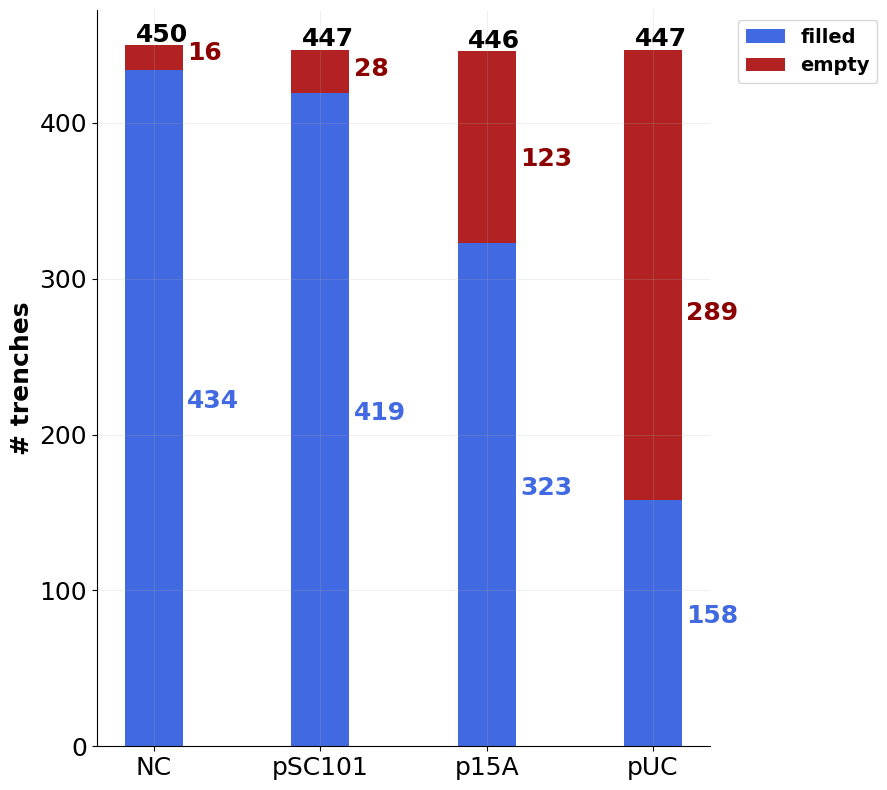

In [95]:
font = {'family': 'serif', 'color':  'royalblue',
        'weight': 'bold', 'size': 18,}
fig = plt.figure(figsize=(9,8), constrained_layout=True, tight_layout=True)
gs = gridspec.GridSpec(1,1, figure=fig)

ax1= fig.add_subplot(gs[0,0])

samples = ['NC','pSC101','p15A','pUC']
n_trenches = interim_info_df.loc[(interim_info_df.colour_channel=='PC') 
                                 & (interim_info_df.timepoint==70)].sample_id.value_counts().loc[samples].to_list()
empty_trenches = interim_info_df.loc[(interim_info_df.colour_channel=='PC') & (interim_info_df.timepoint==70) 
                                     & (interim_info_df.loading_value_tzero==0)].sample_id.value_counts().loc[samples].to_list()
filled_trenches = interim_info_df.loc[(interim_info_df.colour_channel=='PC') & (interim_info_df.timepoint==70) 
                                      & (interim_info_df.loading_value_tzero==1)].sample_id.value_counts().loc[samples].to_list()
width = 0.35       # the width of the bars: can also be len(x) sequence

ax1.bar(samples, filled_trenches, width, label='filled', color='royalblue')
ax1.bar(samples, empty_trenches, width, bottom=filled_trenches,
       label='empty',color='firebrick')
for i, (f,e) in enumerate(list(zip(filled_trenches, empty_trenches))):
    ax1.text(i+0.2, f/2, str(f), fontweight='bold', color='royalblue',fontsize=18,)
    ax1.text(i+0.2, f+e/2.5, str(e), fontweight='bold',color='darkred',fontsize=18,)
    ax1.text(i-0.11, f+e+2.2, str(e+f), fontweight='bold',color='black',fontsize=18,)

plt.yticks(fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("# trenches",fontsize=18, fontweight='bold')
# ax1.set_xlabel("time ",fontsize=18, fontweight='bold')
# ax1.set_xticks(x, samples)
ax1.grid(True,alpha=0.2)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# ax1.set_ylim(-700, 58_100)
# ax1.set_xlim(-7, 500)
plt.legend(prop={'size': 14,'weight':'bold'})
lgd = ax1.legend(bbox_to_anchor=(1.03, 1.0), prop={'size': 14,'weight':'bold'})
#plt.savefig(f"reporter_confidence_intervals_STD.png", dpi=300)
# plt.savefig(f"trench_loading_efficiency.png",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Loading Analysis Checkup

In [107]:
here = interim_info_df.loc[(interim_info_df.colour_channel=='PC') & 
                               (interim_info_df.timepoint==70) & 
                               (interim_info_df.loading_value_tzero==1) & (interim_info_df.sample_id=='pUC')]

In [108]:
@interact
def show_pUC(x=(0,len(here)-1),
            time=(0,99)):
    
    new_im = interim_info_df.loc[(interim_info_df.colour_channel=='PC') & 
                                 (interim_info_df.timepoint==time) & 
                                 (interim_info_df.loading_value_tzero==1) & (interim_info_df.sample_id=='pUC')]
    print(new_im.trench_cum.iloc[x])
    plt.close()
    imshow(convert_to_nparray(new_im.directory.iloc[x]))
    plt.show()

interactive(children=(IntSlider(value=78, description='x', max=157), IntSlider(value=49, description='time', m…

## Save updated metadata

In [109]:
interim_info_df#.to_csv('3_trench_master_tiff/trench_master_metadata.csv',index=False)

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id,loading_value_tzero
0,2_sliced_trenches/xy000_tr0_Green_T0000.png,xy000,0,Green,0,0,xy000_tr00,15,NC,1
1,2_sliced_trenches/xy000_tr0_Green_T0001.png,xy000,0,Green,1,0,xy000_tr00,15,NC,1
2,2_sliced_trenches/xy000_tr0_Green_T0002.png,xy000,0,Green,2,0,xy000_tr00,15,NC,1
3,2_sliced_trenches/xy000_tr0_Green_T0003.png,xy000,0,Green,3,0,xy000_tr00,15,NC,1
4,2_sliced_trenches/xy000_tr0_Green_T0004.png,xy000,0,Green,4,0,xy000_tr00,15,NC,1
...,...,...,...,...,...,...,...,...,...,...
536995,2_sliced_trenches/xy127_tr4_mCherry_T0095.png,xy127,4,mCherry,95,1789,xy127_tr04,5,pUC,1
536996,2_sliced_trenches/xy127_tr4_mCherry_T0096.png,xy127,4,mCherry,96,1789,xy127_tr04,5,pUC,1
536997,2_sliced_trenches/xy127_tr4_mCherry_T0097.png,xy127,4,mCherry,97,1789,xy127_tr04,5,pUC,1
536998,2_sliced_trenches/xy127_tr4_mCherry_T0098.png,xy127,4,mCherry,98,1789,xy127_tr04,5,pUC,1


---
OLD CODE


# Save into Zarr folder
-> only loaded trenches!

In [148]:
len(interim_info_df.trench_cum.unique()), len(interim_info_df.loc[interim_info_df.loading_value_tzero==1].trench_cum.unique())
empty_removed_trench_df = interim_info_df.loc[interim_info_df.loading_value_tzero==1]

In [149]:
unique_original_trench_idx = interim_info_df.loc[interim_info_df.loading_value_tzero==1].trench_cum.unique()
new_filled_trench_idx = list(range(len(unique_original_trench_idx)))
conversion_dict = dict(zip(unique_original_trench_idx, new_filled_trench_idx))

In [150]:
empty_removed_trench_df['trench_filled_cum'] = empty_removed_trench_df.trench_cum.apply(lambda x: conversion_dict[x])

/var/folders/p_/d1kqy0fj5497sqkd5nkn_rf40000gn/T/ipykernel_56602/680748958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_removed_trench_df['trench_filled_cum'] = empty_removed_trench_df.trench_cum.apply(lambda x: conversion_dict[x])


In [152]:
empty_removed_trench_df#.to_csv('3_trench_master_tiff/filled_trench_master_metadata.csv',index=False)

,directory,FOV,trench,colour_channel,timepoint,trench_cum,trench_id,trench_no_per_FOV,sample_id,loading_value_tzero,trench_filled_cum
0,2_sliced_trenches/xy000_tr0_Green_T0000.png,xy000,0,Green,0,0,xy000_tr00,15,NC,1,0
1,2_sliced_trenches/xy000_tr0_Green_T0001.png,xy000,0,Green,1,0,xy000_tr00,15,NC,1,0
2,2_sliced_trenches/xy000_tr0_Green_T0002.png,xy000,0,Green,2,0,xy000_tr00,15,NC,1,0
3,2_sliced_trenches/xy000_tr0_Green_T0003.png,xy000,0,Green,3,0,xy000_tr00,15,NC,1,0
4,2_sliced_trenches/xy000_tr0_Green_T0004.png,xy000,0,Green,4,0,xy000_tr00,15,NC,1,0
...,...,...,...,...,...,...,...,...,...,...,...
536995,2_sliced_trenches/xy127_tr4_mCherry_T0095.png,xy127,4,mCherry,95,1789,xy127_tr04,5,pUC,1,1333
536996,2_sliced_trenches/xy127_tr4_mCherry_T0096.png,xy127,4,mCherry,96,1789,xy127_tr04,5,pUC,1,1333
536997,2_sliced_trenches/xy127_tr4_mCherry_T0097.png,xy127,4,mCherry,97,1789,xy127_tr04,5,pUC,1,1333
536998,2_sliced_trenches/xy127_tr4_mCherry_T0098.png,xy127,4,mCherry,98,1789,xy127_tr04,5,pUC,1,1333


In [147]:
import zarr
from numcodecs import Blosc

In [159]:
channel_dict = {0:'PC', 1:'mCherry', 2:'Green'}
for trench_idx in tqdm(data_df.trench_filled_cum.unique()):
    for channel in [0, 1, 2]:
        for timepoint in data_df.timepoint.unique():
            current_trench_im = convert_to_nparray(data_df.loc[(data_df.trench_filled_cum==trench_idx)
                                                               & (data_df.colour_channel==channel_dict[channel])
                                                               & (data_df.timepoint==timepoint)].directory.iloc[0])
            z1[trench_idx,channel,timepoint] = current_trench_im

  0%|          | 0/1334 [00:00<?, ?it/s]

In [298]:
z1

<zarr.core.Array (1790, 3, 100, 650, 73) int32>

In [303]:
z1[1000,0,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [163]:
@interact
def show(x=(0,len(z1)-1),
         time=(0,99),
         channel=(0,2)):
    imshow(z1[x,channel,time])

interactive(children=(IntSlider(value=666, description='x', max=1333), IntSlider(value=49, description='time',…

In [ ]:
reporter_ims_master_array = memmaped_trench_master_tiff[:,0,:, :,:]
PC_ims_master_array = memmaped_trench_master_tiff[:,1,:, :,:]
segm_ims_master_array = memmaped_trench_master_tiff[:,2,:, :,:]
mask_master_array = memmaped_trench_master_tiff[:,3,:, :,:]

In [ ]:
segm_ims_master_array.shape

Visually inspect pre-master TIFF:

In [ ]:
viewer = napari.view_image(segm_ims_master_array, rgb=False,colormap='red')
viewer.add_image(reporter_ims_master_array, rgb=False,colormap='yellow')
viewer.add_image(PC_ims_master_array, rgb=False,colormap='gray')
viewer.add_image(mask_master_array, rgb=False)